# Создание сервиса на основе системы Drools

Разрабатываемый сервис ожидает на вход информацию о происходящих в системе событиях и характеристиках объектов в виде набора фактов, накапливает и агрегирует эту информацию, а также выдает заявки на выполнение операций по обработке.

## Исходные данные для проектирования

**Экспертом сформулировано следующее описание процесса.**

Участок сборки принимает в поступающие лотки детали двух типов: "барабан" и "болт". Барабан - устройство, направляющее возвратно-поступательное и (или) вращательное движение сопряженных деталей, сборочных единиц.  Винт - крепежное изделие, служащее для соединения деталей путем ввинчивания в резьбовое отверстие в одном из соединяемых изделий или для фиксации соединяемых узлов и деталей с основными элементами. Имеет вид стержня с наружной резьбой на одном конце, с головкой для передачи крутящего момента на другом. Имеет, при необходимости, стопорящие элементы.

Каждая деталь взвешивается и помещается во входной накопитель участка, а информация о ней (тип, идентификатор и вес) передается сервису принятия решений в виде набора фактов.

Вес детали используется для принятия решения по отбраковке неподходящих комплектующих. Масса каждой детали не должна превышать 130 грамм. Для неподходящих деталей должна оформляться заявка на перенос в лоток для бракованных комплектующих с указанием её идентификатора.

По мере появления в накопителе участка нужных для сборки деталей требуемого качества сервисом оформляется заявка на сборку агрегата с указанием идентификаторов комплектующих. В зависимости от типа агрегата результат сборки передается либо в лотки хранения участка, либо на конвеер готовой продукции.

На участке собирается два типа агрегатов. Для сборки первого типа необходим один барабан и 7 болтов, а для второго - агрегат первого типа, 2 дополнительных барабана и 17 болтов. Агрегаты второго типа являются выходной продукцией участка.


## Проектирование сервиса

На основе анализа представленной от эксперта информации можно составить принципиальную схему процесса работы на участке.

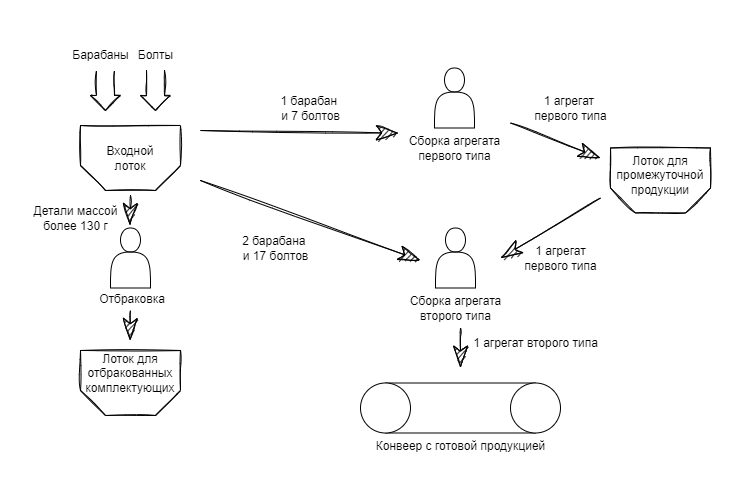

В качестве подсистемы логического вывода выбирается система продукционных правил Drools, так как задача подразумевает работу с множеством объектов нескольких типов (детали, болты, барабаны, агрегаты двух типов), над которыми необходимо производить преобразования по логическим правилам.

Ключевой особенностью системы Drools с точки зрения продукционных правил является объектно-ориентированная модель фактов, позволяющая задавать правила для классов иерархии, например, определять правила для базовых классов, которые автоматически будут применены ко всем производным. В нашем случае правило отбраковки деталей по массе не зависит от типа деталей, а значит может быть сформулировано на уровне базовго класса "Деталь". Тогда производными от класса "Деталь" будут "Болт", "Барабан", "Агрегат с типом 1" и "Агрегат с типом 2". Описание иерархии и содержимого типов для фактов зададим с помощью обычных классов языка Java. Отдельный тип фактов будет заведен под "Задачу команде", с помощью которой будет выдаваться результат работы системы (список задач как список фактов с типом "Задача").

Алгоритм логического вывода подсистемы Drools относится к усовершенствованному подвиду алгоритмов Rete, а значит позволяет накапливать и эффективным образом обрабатывать поступающие в систему факты с помощью "продукций" (конструкций "если-то").

В рассматриваемом примере необходимо сделать несколько правил исходя из описания задачи экспертом.

1. Отбраковка деталей из входящего накопителя.
2. Создание задач на сборку агрегатов первого типа при накоплении как минимум 1 барабана и 7 болтов.
3. Создание задач на сборку агрегатов второго типа при накоплении как минимум 1 агрегата первого типа, 2 барабанов и 17 болтов.

При этом необходимо расставить уровни приоритетов правил, чтобы избежать двух проблем. Первая состоит в возможном попадании бракованных деталей в агрегаты, если отбраковка будет выполняться после формирования задач на сборку. Вторая проблема состоит в том, что сборка агрегатов первого и второго типа конкурируют между собой, при этом второй тип зависит от первого и требует большего числа деталей. Таким образом, при неверной расстановке приоритетов между сборкой агрегатов первого и второго типа склад будет затоварен агрегатами первого типа, так как для его сборки предполагается меньше требований, чем для второго.

Указанные выше проблемы могут быть решены расстановкой следующих приоритетов правил.

1. Первым приоритетом должна быть отбраковка, так как использование деталей неподходящего качества недопустимо.
2. Вторым приоритетом пойдет сборка агрегатов второго типа, так как он зависит от сборки агрегатов первого типа и использхует тот же набор деталей (барабаны и болты), но в большем количестве.
3. Наименьшим приоритетом будет обладать задача сборки агрегатов первого типа.

Указанные выше соображения будут далее использованы для разработки сервиса принятия решений на основе системы Drools.

## Предварительная подготовка файлов проекта

Так как прототип системы ориентирован на среду виртуальной лаборатории Colab или Jupyter необходимо определить ряд вспомогательных команд для создания приложения на языке Java.

In [ ]:
def run(cmd):
  print('>> {}'.format(cmd))
  !{cmd}
  print('')

Проект Maven предполагает определенную структуру директорий, в которых будут находиться файлы с исходным кодом и настройки приложения.

In [ ]:
run('rm -Rv src')
run('mkdir -p src/main/java/org/etu/apu/intelisys/practice/ex3')
run('mkdir -p src/main/resources/org/etu/apu/intelisys/practice/ex3')
run('mkdir -p src/main/resources/META-INF/')

>> rm -Rv src
removed 'src/main/resources/META-INF/kmodule.xml'
removed directory 'src/main/resources/META-INF'
removed 'src/main/resources/org/etu/apu/intelisys/practice/ex3/SortRules.drl'
removed directory 'src/main/resources/org/etu/apu/intelisys/practice/ex3'
removed directory 'src/main/resources/org/etu/apu/intelisys/practice'
removed directory 'src/main/resources/org/etu/apu/intelisys'
removed directory 'src/main/resources/org/etu/apu'
removed directory 'src/main/resources/org/etu'
removed directory 'src/main/resources/org'
removed directory 'src/main/resources'
removed 'src/main/java/org/etu/apu/intelisys/practice/ex3/AppWithRules.java'
removed 'src/main/java/org/etu/apu/intelisys/practice/ex3/Part.java'
removed 'src/main/java/org/etu/apu/intelisys/practice/ex3/Reel.java'
removed 'src/main/java/org/etu/apu/intelisys/practice/ex3/AggregateType1.java'
removed 'src/main/java/org/etu/apu/intelisys/practice/ex3/Task.java'
removed 'src/main/java/org/etu/apu/intelisys/practice/ex3/Scre

## Определение элементов базы фактов
После подготовки структуры директорий можно перейти к описанию бизнес-логики приложения.
Для начала оппределим модель данных, задав 5 типов фактов.

1. "Part" - базовый класс для всех деталей, обладающий характеристикой "масса" и "идентификатор". Для генерации идентификаторов используется статический член класса, инкрементируемый при создании каждой новой детали.

In [ ]:
%%writefile src/main/java/org/etu/apu/intelisys/practice/ex3/Part.java
package org.etu.apu.intelisys.practice.ex3;

public class Part {

    public static int id_counter = 0;

    public Integer id;
    public Double mass;

    public Part(Double mass) {
        this.id = this.id_counter++;
        this.mass = mass;
    }

    public Part() {
        id = null;
        mass = null;
    }

    public String toString() {
        return "(" + id + ", " + mass + ")";
    }
}

Writing src/main/java/org/etu/apu/intelisys/practice/ex3/Part.java


2. "Screw" - базовый класс для выделения деталей с типом "Болт".

In [ ]:
%%writefile src/main/java/org/etu/apu/intelisys/practice/ex3/Screw.java

package org.etu.apu.intelisys.practice.ex3;

public class Screw extends Part {

    public Screw(Double mass) {
        super(mass);
    }

    public Screw() {
        super();
    }

}

Writing src/main/java/org/etu/apu/intelisys/practice/ex3/Screw.java


3. "Reel" - базовый класс для выделения деталей с типом "Барабан".

In [ ]:
%%writefile src/main/java/org/etu/apu/intelisys/practice/ex3/Reel.java

package org.etu.apu.intelisys.practice.ex3;

public class Reel extends Part {

    public Reel(Double mass) {
        super(mass);
    }

    public Reel() {
        super();
    }

}

Writing src/main/java/org/etu/apu/intelisys/practice/ex3/Reel.java


4. "AggregateType1" - базовый класс для выделения деталей с типом "Агрегат с типом 1". В отличии от предыдущих типов строится из списка с "болтами" и "барабана".

In [ ]:
%%writefile src/main/java/org/etu/apu/intelisys/practice/ex3/AggregateType1.java
package org.etu.apu.intelisys.practice.ex3;

import java.util.ArrayList;

import org.etu.apu.intelisys.practice.ex3.Part;
import org.etu.apu.intelisys.practice.ex3.Reel;

public class AggregateType1 extends Part {

    public ArrayList screws;
    public Reel reel;

    public AggregateType1(ArrayList screws, Reel reel) {
        super();
        this.reel = reel;
        this.screws = screws;
    }

    public AggregateType1() {
        super();
    }

    public String toString() {
        return "(id=" + this.id + ")" + "(reel=" + this.reel.toString()
            + ")(screws=" + this.screws.toString() + ")";
    }

}

Writing src/main/java/org/etu/apu/intelisys/practice/ex3/AggregateType1.java


5. "Task" - хранит описание задачи с указанием того, кому поручена работа (отбраковка, сборка агрегата 1 или сборка агрегата 2), а также текстовое описание задачи (в том числе список деталей).

In [ ]:
%%writefile src/main/java/org/etu/apu/intelisys/practice/ex3/Task.java
package org.etu.apu.intelisys.practice.ex3;

public class Task {
    public int id;
    public String task;
    public String team;

    private static int counter = 0;

    public Task(String team, String task) {
        id = counter++;
        this.task = task;
        this.team = team;
    }

    public String toString() {
        return "[" + id + "] Team " + team + ": " + task;
    }
}

Writing src/main/java/org/etu/apu/intelisys/practice/ex3/Task.java


## Создание правил логического вывода

Для описания правил используется DRL-синтаксис, состоящий из конструкции *rule ... when .. then*.

В части when задается шаблон поиска объектов, к которым должно применяться правило. Подходящие под шаблон объекты могут быть помечены с помощью символа "$" и переиспользоваться как в условиях, так и в секции then, например, для извлечения фактов из рабочей памяти или выполнения действий.

Сами шаблоны задаются путем указания прототипа в виде названия класса и набора ограничений, включающих выражение с полями.
Например, чтобы выбрать все детали с массой > 10 грамм и < 100 грамм можно использовать следующую конструкцию.
```
rule "Выбор всех деталей с массой между 10 и 100 грамм"
    when
        $pat: Part(mass >= 10 && mass <= 100) // шаблон поиска
    then
        retract($pat); // удаляем деталь из рабочей области
        // можно добавлять новые факты в рабочую область с
        // помощью команды insert(). На вход могут быть
        // переданы любые объекты классов Java.
        insert(new Task("Контроль качества",
            "Извлечение детали с id " + $pat.id
            + " так как ее масса = " + $pat.mass));
end
```
Для того, чтобы осуществить выбор в правиле не одного объекта, а подмножества, можно использовать конструкцию *from collect(<шаблон поиска>)*. Например, чтобы выбрать больше 3 деталей типа "болт" и затем совершить над ними действие, используем следующую структуру.
```
rule "Выбор всех деталей с типом Болт"
    when
        $screws: ArrayList(size >= 3) from collect(Screw()) // Используем ArrayList для накопления объектов
    then
        // Если нам нужны не все объекты, а, например, только 3
        // из них. Для этого можно удалить из рабочей области
        // только то, что необходимо, тогда остальная часть
        // множества может быть переиспользована
        for(int i = 0; i < 3; ++i) {
            retract($screws.get(i));
        }
end
```
Наконец, в правиле может быть указано больше 1 шаблона, чтобы выбрать для выполнения действия все комбинации шаблонов. Например, если есть необходимость выбрать пары деталей болт и барабан с набором ограничений, то можно использовать следующую конструкцию.
```
rule "Выбор всех пар деталей с набором условий"
    when
        $screw: Screw(mass < 120.0) // болт с массой < 120 грамм
        $reel: Reel(mass > 130.0) // барабан с массой > 130 грамм
    then
        retract($screw);
        retract($reel);
end
```
Отметим, что в части правила then могут использоваться произвольные конструкции языка Java для выполнения необходимых действий в системе.

Отдельно следует отметить возможность выставления приоритетов срабатывания правилам с помощью ключевого слова salience и указанием числового значения (приоритета - чем больше число, тем первее оно будет в очереди исполнения).

Дополнительно к правилам могут быть определены именованные запросы с помощью конструкции *query*, которые позволяют по параметризованному шаблону вернуть множество объектов (см. пример в коде).

Таким образом, с помощью нотации DRL могут быть описаны все правила, которые необходимы для представления предметной области.





In [ ]:
%%writefile src/main/resources/org/etu/apu/intelisys/practice/ex3/SortRules.drl
package org.etu.apu.intelisys.practice.ex3;

import java.util.List
import java.util.ArrayList

rule "Проверка качества деталей"
    salience 100
	when
		$part: Part(mass > 130.0)
  	then
        retract($part);
		insert(new Task("Контроль качества", "Отбраковать деталь "
            + $part.id + " массой " + $part.mass));
	end

rule "Заявка на сборку первого типа деталей"
    salience 1
    when
        $reel: Reel()
        $screws: ArrayList(size >= 7) from collect(Screw())
    then
        retract($reel);
        ArrayList<Object> list = new ArrayList();
        for(int i = 0; i < 7; ++i) {
            list.add($screws.get(i));
            retract($screws.get(i));
        }
        insert(new AggregateType1($screws, $reel));
        insert(new Task("Сборка агрегата первого типа",
            "Собрать агрегат первого типа из барабана " + $reel.toString()
            + " и болтов: " + list.toString()));
    end

rule "Заявка на сборку второго типа деталей"
    salience 50
    when
        $agg1: AggregateType1()
        $reels: ArrayList(size >= 2) from collect(Reel())
        $screws: ArrayList(size >= 17) from collect(Screw())
    then
        retract($agg1);
        List screw_list = new ArrayList();
        for(int i = 0; i < 7; ++i) {
            screw_list.add($screws.get(i));
            retract($screws.get(i));
        }
        List reel_list = new ArrayList();
        for(int i = 0; i < 2; ++i) {
            reel_list.add($reels.get(i));
            retract($reels.get(i));
        }
        insert(new Task("Сборка агрегата второго типа",
            "Собрать агрегат второго типа из одного агрегата первого типа: "
            + $agg1.toString() + " , а также барабанов " + reel_list.toString()
            + " и болтов: " + screw_list.toString()));
    end

query "Получить план для команды" (target)
	result: Task(team == target)
end

Writing src/main/resources/org/etu/apu/intelisys/practice/ex3/SortRules.drl


## Подготовка тестового приложения

Для проверки подготовленной модели системы создадим простое приложение, передающее в рабочую память сессии Drools предопределенный набор фактов, описывающих поступившие на участок детали. Далее после активации всех правил выполним запрос на получение списка задач для трех команд участка - на отбраковку, на сборку агрегатов первого типа и на сборку агрегатов второго типа.

В реальном приложении вместо предопределенной в коде последовательности фактов подобные манипуляции могут выполняются отдельными запросами к сервису.

In [ ]:
%%writefile src/main/java/org/etu/apu/intelisys/practice/ex3/AppWithRules.java
package org.etu.apu.intelisys.practice.ex3;

import java.io.IOException;
import java.io.Reader;

import org.kie.api.runtime.KieSession;
import org.kie.api.KieServices;
import org.kie.api.runtime.KieContainer;
import org.kie.api.runtime.rule.QueryResults;
import org.kie.api.runtime.rule.QueryResultsRow;
import org.kie.api.runtime.rule.FactHandle;

import org.etu.apu.intelisys.practice.ex3.Part;
import org.etu.apu.intelisys.practice.ex3.Screw;
import org.etu.apu.intelisys.practice.ex3.Reel;
import org.etu.apu.intelisys.practice.ex3.Task;

public class AppWithRules {
    public static void main(String[] args) throws IOException {
		AppWithRules drools = new AppWithRules();
		drools.executeDrools();
	}

	public void executeDrools() throws IOException {

		KieServices kieService = KieServices.Factory.get();

		KieContainer kContainer =  kieService.getKieClasspathContainer();

		KieSession session = kContainer.newKieSession();

		Part[] inputFacts = {
			new Reel(129.0),
			new Reel(131.0),
			new Reel(127.0),
			new Reel(123.0),
			new Screw(132.0),
			new Screw(110.0),
			new Screw(112.0),
			new Screw(137.0),
			new Screw(102.0),
			new Screw(110.0),
			new Screw(112.0),
			new Screw(127.0),
			new Screw(115.0),
			new Screw(138.1),
			new Screw(109.0),
			new Screw(126.0),
			new Screw(125.5),
			new Screw(102.4),
			new Screw(110.5),
			new Screw(112.6),
			new Screw(127.7),
			new Screw(115.8),
			new Screw(138.3),
			new Screw(119.0),
			new Screw(106.0),
			new Screw(123.3),
			new Screw(102.2),
			new Screw(110.1),
			new Screw(112.4),
			new Screw(127.6),
			new Screw(115.4),
			new Screw(115.1)
		};

		for(Part it: inputFacts ) {
			session.insert(it);
		}

		System.out.println("===== Активация всех правил =====");
		session.fireAllRules();

		System.out.println("===== Список фактов в системе ====");
		for(FactHandle facts: session.getFactHandles()) {
			System.out.println(facts.toString());
		}

		System.out.println("===== Задаем вопрос системе \"План работы участка\" =====");
		String[] teams = {
			"Контроль качества", "Сборка агрегата второго типа",
			"Сборка агрегата первого типа"
		};
		for(String team: teams) {
			QueryResults result = session.getQueryResults("Получить план для команды",
				team);
			System.out.println("Число заявок для команды " + team + ": " + result.size());
			for(QueryResultsRow res: result) {
				System.out.println("Найденый факт:" + res.get("result").toString());
			}
		}
    }
}

Writing src/main/java/org/etu/apu/intelisys/practice/ex3/AppWithRules.java


## Сборка и запуск приложения

Для сборки приложения необходимо описать набор зависимостей в виде XML-файла.

In [ ]:
%%writefile pom.xml
<project xmlns="http://maven.apache.org/POM/4.0.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://maven.apache.org/POM/4.0.0 http://maven.apache.org/xsd/maven-4.0.0.xsd">
    <modelVersion>4.0.0</modelVersion>

    <parent>
        <groupId>org.springframework.boot</groupId>
        <artifactId>spring-boot-starter-parent</artifactId>
        <version>2.5.6</version>
        <relativePath/> <!-- lookup parent from repository -->
    </parent>

    <groupId> org.etu.apu.intelisys.practice.ex2</groupId>
    <artifactId>ex2-drools</artifactId>
    <properties>
        <maven.compiler.source>1.8</maven.compiler.source>
        <maven.compiler.target>1.8</maven.compiler.target>
        <drools-version>7.60.0.Final</drools-version>
    </properties>
    <version>0.0.1-SNAPSHOT</version>


	<dependencies>

        <dependency>
            <groupId>org.springframework.boot</groupId>
            <artifactId>spring-boot-starter</artifactId>
        </dependency>

        <dependency>
            <groupId>org.kie.kogito</groupId>
            <artifactId>kogito-rules-spring-boot-starter</artifactId>
            <version>1.12.0.Final</version>
        </dependency>

        <dependency>
            <groupId>org.kie</groupId>
            <artifactId>kie-api</artifactId>
            <version>${drools-version}</version>
        </dependency>

        <dependency>
            <groupId>org.drools</groupId>
            <artifactId>drools-compiler</artifactId>
            <version>${drools-version}</version>
        </dependency>
        <dependency>
            <groupId>org.drools</groupId>
            <artifactId>drools-core</artifactId>
            <version>${drools-version}</version>
        </dependency>

        <dependency>
            <groupId>org.drools</groupId>
            <artifactId>drools-mvel</artifactId>
            <version>${drools-version}</version>
        </dependency>

	</dependencies>

    <build>
        <plugins>
            <plugin>
                <groupId>org.kie</groupId>
                <artifactId>kie-maven-plugin</artifactId>
                <version>7.60.0.Final</version>
                <extensions>true</extensions>
            </plugin>
        </plugins>
    </build>
</project>

Overwriting pom.xml


Для подключения правил необходимо добавить файл с описанием схемы Drools.

In [ ]:
%%writefile src/main/resources/META-INF/kmodule.xml
<kmodule xmlns="http://www.drools.org/xsd/kmodule"/>

Writing src/main/resources/META-INF/kmodule.xml


Чтобы собрать программу необходимо установить Java Developer Kit версии 11, а также систему сборки приложений Maven для языка Java.

In [ ]:
run('apt-get update > /dev/null')
run('apt-get upgrade > /dev/null')

run('apt-get install openjdk-11-jdk > /dev/null')

run('apt-get install maven > /dev/null')

run('javac -version')
run('mvn -version')

>> apt-get update > /dev/null

>> apt-get upgrade > /dev/null

>> apt-get install openjdk-11-jdk > /dev/null

>> apt-get install maven > /dev/null

>> javac -version
javac 11.0.21

>> mvn -version
Apache Maven 3.6.3
Maven home: /usr/share/maven
Java version: 11.0.21, vendor: Ubuntu, runtime: /usr/lib/jvm/java-11-openjdk-amd64
Default locale: en_US, platform encoding: UTF-8
OS name: "linux", version: "6.1.58+", arch: "amd64", family: "unix"



Сборка и запуск приложения - результат в конце лога.

In [ ]:
run('mvn package spring-boot:run')

>> mvn package spring-boot:run
[INFO] Scanning for projects...
[INFO] 
[INFO] -----------< org.etu.apu.intelisys.practice.ex2:ex2-drools >------------
[INFO] Building ex2-drools 0.0.1-SNAPSHOT
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- maven-resources-plugin:3.2.0:resources (default-resources) @ ex2-drools ---
[INFO] Using 'UTF-8' encoding to copy filtered resources.
[INFO] Using 'UTF-8' encoding to copy filtered properties files.
[INFO] Copying 0 resource
[INFO] Copying 2 resources
[INFO] 
[INFO] --- maven-compiler-plugin:3.8.1:compile (default-compile) @ ex2-drools ---
[INFO] Changes detected - recompiling the module!
[INFO] Compiling 6 source files to /content/target/classes
[INFO] 
[INFO] --- maven-resources-plugin:3.2.0:testResources (default-testResources) @ ex2-drools ---
[INFO] Using 'UTF-8' encoding to copy filtered resources.
[INFO] Using 'UTF-8' encoding to copy filtered properties files.
[INFO] skip non existing resour